In [3]:
import pandas as pd

In [2]:
import time, itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline

#from custom_funcs import *

from ema_workbench import (Model, IntegerParameter, RealParameter, CategoricalParameter, Constant,
                           ScalarOutcome, MultiprocessingEvaluator, Policy, Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.util import ema_logging, save_results, load_results
from ema_workbench.analysis import prim, feature_scoring

from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\ProgramData\Anaconda3\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [29]:
dike_model,planning_steps = get_model_for_problem_formulation(2)

In [31]:
policy_rfr = {}
for key in dike_model.levers:
    _,s = key.name.split('_')
    if 'RfR' in s:
        policy_rfr.update({key.name:np.random.binomial(1,0.33333,1)})
    else:
        policy_rfr.update({key.name:np.zeros(1)})
policies_to_evaluate = [Policy('policy_rfr'+str(i),**policy.to_dict())
                        for i,policy in pd.DataFrame.from_dict(policy_rfr).iterrows()]

In [32]:
n_scenarios = 3000

start = time.time()
with MultiprocessingEvaluator(dike_model) as evaluator:
#    results,experiments = evaluator.perform_experiments(scenarios=n_scenarios, policies = policy0)
    experiments,results = evaluator.perform_experiments(scenarios=n_scenarios, policies = policies_to_evaluate)
    end = time.time()
print(end - start, "secs")

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 3000 scenarios * 1 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


3834.181992292404 secs


In [33]:
results_df = pd.DataFrame.from_dict(results) 
final_df = pd.concat([experiments,results_df],axis=1,sort=False)
final_df.to_csv('results_rfr.csv',index=False)

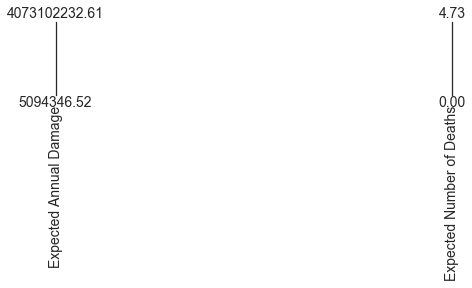

In [5]:
rfr = pd.read_csv('results_rfr.csv')
rfr.head()
#rfr['total investment'] =  dike_inc['Dike Investment Costs']
outcomes = rfr.loc[:, ['Expected Annual Damage','Expected Number of Deaths']]
from ema_workbench.analysis import parcoords

limits = parcoords.get_limits(outcomes)
axes = parcoords.ParallelAxes(limits)
#axes.plot(outcomes,figsize=(8,10))

# we invert this axis so direction of desirability is the same 
#axes.invert_axis('max_P') 
plt.show()

In [7]:
outcomes['failure'] = outcomes[outcomes['Expected Number of Deaths']<=0.00001]
#outcomes['failure'] = np.where(outcomes['Expected Annual Damage']<=100000,1,0)
#outcomes['failure'] = np.where(outcomes['Expected Number of Deaths']>=0.1,1,0)
df_new = outcomes[outcomes['failure']==1]
len(df_new)

0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until
[MainProcess/INFO] 3000 points remaining, containing 973 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.149, coverage: 0.45940390544707094, density: 1.0 restricted_dimensions: 1


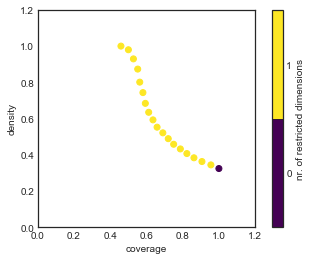

In [11]:
from ema_workbench.analysis import (prim,cart)
y = outcomes['failure'].values
x = rfr.ix[:,1:16]
ema_logging.log_to_stderr(ema_logging.INFO);
prim_alg = prim.Prim(x, y, threshold=0.8, peel_alpha=0.1)
box1 = prim_alg.find_box()
import matplotlib.pyplot as plt
 
box1.show_tradeoff()
plt.show()

coverage    0.459404
density            1
id                18
mass           0.149
mean               1
res_dim            1
Name: 18, dtype: object

             box 18                                          
                min      max                        qp values
A.3_pfail  0.000096  0.14885  [-1.0, 2.5896360981090828e-219]



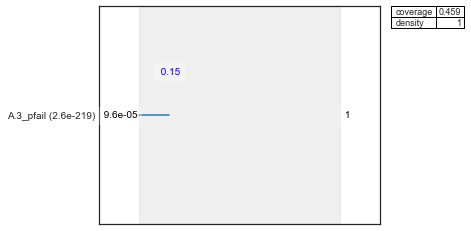

In [12]:
box1.inspect()
box1.inspect(style='graph')
plt.show()